In [1]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using data
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [2]:
Eoff=5.0
Ts=collect(300.0:20.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[-1.8e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e18]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.0]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])

effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTx,x::Float64)
    Da=9.0-1.5*x*x
    Dv=4.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTx(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTx(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTx(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTx(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandX3,bandX3,bandX3],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2

xmax=3.0

3.0

In [3]:
X1effMass(0.6)

0.49012

In [4]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 12.437884 seconds (65.19 M allocations: 9.188 GiB, 9.93% gc time)


3.0

In [5]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [6]:
xxsp=0.6
xsp=(100-xxsp)/100
Eep=7.0
etha=0.96
thetaD=350.0#524.0
#gammaSA,GM,Tts[Tti],MSiGecgs(xsp),thetaD,omegaD,beta,delta,Eep,mds,etha

Tt=thetaD
gammaSA=2.02
beta=2.0

eps=39
deltaSi=6.39e-10
deltaGe=6.77e-10
delta=deltaSi*(1-xsp)+deltaGe*xsp
deltacgs=delta*100
V=((1-xsp)*(6.39e-10)^3+xsp*(6.77e-10)^3)/12
MSiGecgs(xsp)=(2*(24.305)+(28.0855*(1-xsp)+118.71*xsp))/3
#G=1.033*(1-xsp)+1.017*xsp

a3=((1-xsp)*(6.39e-10)^3+xsp*(6.77e-10)^3)/12
a1=a3^(1/3)
#vtt=kB/hbar*(6*pi*pi)^(-1/3)*thetaD*delta
dd=(4.66e-26*(1-xsp)+1.206e-25*xsp)/(2e-29*(1-xsp)+2.2636e-29*xsp)

delMSiGe=(2*(24.305)+(28.0855*(1-xsp)-118.71*xsp))/3
deldelta=deltaSi-deltaGe
mbar=(28.0855*(1-xsp)+118.71*xsp)
GM=(1-xsp)*((28.0855-mbar)/mbar)^2+xsp*((118.71-mbar)/mbar)^2

omegaD=thetaD*kB/hbar
mds=0.5*me#0.427*me
#vt=5880.0

4.55469178e-31

In [7]:
function tauPH_U_SAT(gamma::Float64,intx::Array{Float64},T::Float64,M::Float64,
    theta::Float64,omegaD::Float64,beta::Float64,delta::Float64)
    #intx is different from x in oither phonon calculations intx=omega/omegaD
    Mcgs=M
    #println("Mcgs= ",Mcgs)
    deltacgs=delta*100
    #println("deltacgs= ",deltacgs)
    #println("1/Mcgs/deltacgs^2/(theta/T)= ",(1/Mcgs/deltacgs^2/(theta/T)))
    return 1 ./((3.264e-2) .*((1 .+beta .*(5/9)) ./(1 .+beta))*gamma^2 .*intx.^2 ./Mcgs/deltacgs^2/(theta/T))    
end

tauPH_U_SAT (generic function with 1 method)

In [8]:
function tauPH_EP_SAT(Eep::Float64,md::Float64,x::Array{Float64},Ef::Float64,
    T::Float64,M::Float64,theta::Float64,delta::Float64)
    eta=Ef#Ef*q/kB/T
    deltacgs=delta*100
    Mcgs=M
    A=6.76e26(md/me)^2*deltacgs^2/Mcgs
    y=3.72e9(md/me)*deltacgs^2*theta
    D=1.68e-11/(md/me)/deltacgs^2/theta
    alphat=thetaD/T
    #println("alphat ",alphat)
    lambda=3
    ex1=1 .+exp.(-alphat*y .+eta .-D*alphat*x.*x .+alphat.*x/2)
    ex2=1 .+exp.(-alphat*y .+eta .-D*alphat*x.*x .-alphat.*x/2)    
    ext=ex1 ./ex2
    logt=log.(ext)
    return 1 ./(lambda .*(A .*Eep .^2 ./alphat) .*logt) 
end

function tauPH_PD_SAT(GM::Float64,intx::Array{Float64},theta::Float64)
    return 1 ./(6.17e11*theta*GM .*intx.^4)
end

tauPH_PD_SAT (generic function with 1 method)

In [9]:
function I1(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)
    alphat=thetaD/Tt
    tauPH_U_SA_Af(x)=tauPH_U_SAT(gammaSA,x,Tt,MSiGecgs,thetaD,omegaD,beta,delta)
    #tauPH_N_SA_Af(x)=tauPH_U_SA_A(x)/(1+beta)
    tauPH_EP_SA_Af(x)=tauPH_EP_SAT(Eep,mds,x,etha,Tt,MSiGecgs,thetaD,delta)
    tauPH_PD_SA_Af(x)=tauPH_PD_SAT(GM,x,thetaD)
    tauPH_C_SA_Af(x)=1 ./((beta+1)./tauPH_U_SA_Af(x)+1 ./tauPH_EP_SA_Af(x)+1 ./tauPH_PD_SA_Af(x))
    
    integrand(x)=tauPH_C_SA_Af(x) .*(x .^4) .*alphat^2 .*exp.(alphat .*x)./(exp.(alphat*x) .-1).^2
    
    nodes, weights = qnwlege(1000,0.0,1.0)
    return a= do_quad(integrand,nodes, weights)    
end

I1 (generic function with 1 method)

In [10]:
function I2(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)
    alphat=thetaD/Tt
    tauPH_U_SA_Af(x)=tauPH_U_SAT(gammaSA,x,Tt,MSiGecgs,thetaD,omegaD,beta,delta)
    #tauPH_N_SA_Af(x)=tauPH_U_SA_A(x)/(1+beta)
    tauPH_EP_SA_Af(x)=tauPH_EP_SAT(Eep,mds,x,etha,Tt,MSiGecgs,thetaD,delta)
    tauPH_PD_SA_Af(x)=tauPH_PD_SAT(GM,x,thetaD)
    tauPH_C_SA_Af(x)=1 ./((beta+1)./tauPH_U_SA_Af(x)+1 ./tauPH_EP_SA_Af(x)+1 ./tauPH_PD_SA_Af(x))
    
    integrand(x)=beta*tauPH_C_SA_Af(x)./tauPH_U_SA_Af(x).*(x.^4)*alphat^2 .*exp.(alphat*x)./(exp.(alphat*x) .-1).^2
    
    nodes, weights = qnwlege(1000,0.0,1.0)
    return a= do_quad(integrand,nodes, weights)    
end

function I3(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)
    alphat=thetaD/Tt
    tauPH_U_SA_Af(x)=tauPH_U_SAT(gammaSA,x,Tt,MSiGecgs,thetaD,omegaD,beta,delta)
    #tauPH_N_SA_Af(x)=tauPH_U_SA_A(x)/(1+beta)
    tauPH_EP_SA_Af(x)=tauPH_EP_SAT(Eep,mds,x,etha,Tt,MSiGecgs,thetaD,delta)
    tauPH_PD_SA_Af(x)=tauPH_PD_SAT(GM,x,thetaD)
    tauPH_C_SA_Af(x)=1 ./((beta+1)./tauPH_U_SA_Af(x)+1 ./tauPH_EP_SA_Af(x)+1 ./tauPH_PD_SA_Af(x))
    
    integrand(x)=beta*1 ./tauPH_U_SA_Af(x).*
    (1 .-beta*tauPH_C_SA_Af(x) ./tauPH_U_SA_Af(x)).*(x.^4)*alphat^2 .*exp.(alphat*x)./(exp.(alphat*x) .-1).^2
    
    nodes, weights = qnwlege(1000,0.0,1.0)
    return a= do_quad(integrand,nodes, weights)    
end


I3 (generic function with 1 method)

In [11]:

function klt(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)    
    I1t=I1(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)
    I2t=I2(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)
    I3t=I3(gammaSA,GM,Tt,MSiGecgs,thetaD,omegaD,beta,delta,Eep,mds,etha)
    return 4.67e-2*(thetaD^2/delta/100)*(I1t+I2t.^2/I3t)#(I1t+I2t.^2/I3t)#(kB*thetaD/hbar)^3*(I1t+I2t.^2/I3t)    #4.67e-2*(thetaD^2/delta/100)*(I1t+I2t.^2/I3t)    
end
klt_SA_A=Array{Float64,1}(undef,length(Ts))
for Tti in 1:length(Ts)
    klt_SA_A[Tti]=klt(gammaSA,GM,Ts[Tti],MSiGecgs(xsp),thetaD,omegaD,beta,delta,Eep,mds,
        Efsr[Tti,1,1]/kBe/Ts[Tti])
    #klt_V_A[Tti]=kltV(gammaSA,Tts[Tti],MSiGecgs(xsp),thetaD,omegaD,beta,delta,Eep,mds,etha,vtt,dd)*(thetaD/Ttt)^2    
end

In [12]:
MgSiSn4hKCT=[27.204980536447565,125.22263104569937,250.3986028902043, 300.61256865568174,350.4225990508186, 400.31661600810537,
450.60323681544304,500.88852450274595,550.37460672959,]
MgSiSn4hKCK=[ 2.8789473684210525, 2.7375, 2.609210526315789, 2.5121710526315786, 2.4184210526315786, 2.531907894736842, 2.614144736842105
, 2.6930921052631573, 2.7999999999999994]
MgSiSn2hKCT=[27.174994546327184, 125.66321921825845, 250.56521889830958, 300.8030294412153, 350.04276302458277,400.3366068836394, 
450.6409643790327, 500.95101524496823,550.7594666065552]
MgSiSn2hKCK=[2.608956937799043, 2.4846513157894736, 2.4523355263157893, 2.3861330409356722, 2.3131756578947367
, 2.385235380116959, 2.4832374999999995, 2.595288011695906, 2.697641746411483]
MgSiSn05hKCT=[26.1867119039,124.6184700145,249.7991072943,300.1809590466,349.8324946796,399.3641637338,450.1016014407,
450.7811561579,549.7232004091,500.4092678505]
MgSiSn05hKCK=[2.4217028509,2.3627326555,2.2459551435,2.1025076754,2.0223385167,2.2370652412,2.3803594498,2.302875,
2.5966549043,2.5105263158]
MgSiSn2h2TiO2KCT=[450.7811561579,26.5677491601,125.429931211,250.6172345758,300.4185996907,350.6278995361,
400.1639737642,500.3759398496,550.2639577668]
MgSiSn2h2TiO2KCK=[2.302875,2.3065789474,2.2490131579,2.1486842105,2.0335526316,1.925,2.1552631579,2.4282894737,
2.5269736842]
MgSiSn2h5TiO2KCT=[27.3549565403,124.5907321495,250.1753052845,299.9806697595,350.1926358449,400.1339785634,
450.0339945609,500.3299472084,550.6152348958]
MgSiSn2h5TiO2KCK=[2.2490131579,2.1782894737,2.0582236842,1.9529605263,1.8509868421,2.08125,2.2095394737,2.3148026316,
2.39375]
MgSiSn0hKCT=[26.9755694846,125.1437396683,250.3474884019,300.0735322348,349.8027683571,400.6191835973,449.916314723,
500.2366154749,550.052698235]
MgSiSn0hKCK=[2.1168755981,2.0268355263,1.9150855263,1.8140986842,1.7209888158,1.8544934211,1.9231644737,2.0605065789,
2.1816907895]

9-element Array{Float64,1}:
 2.1168755981
 2.0268355263
 1.9150855263
 1.8140986842
 1.7209888158
 1.8544934211
 1.9231644737
 2.0605065789
 2.1816907895

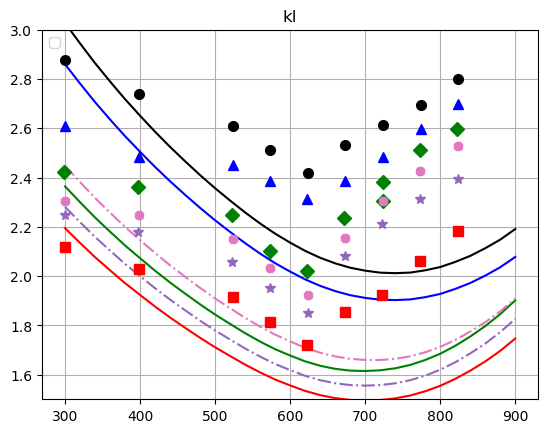

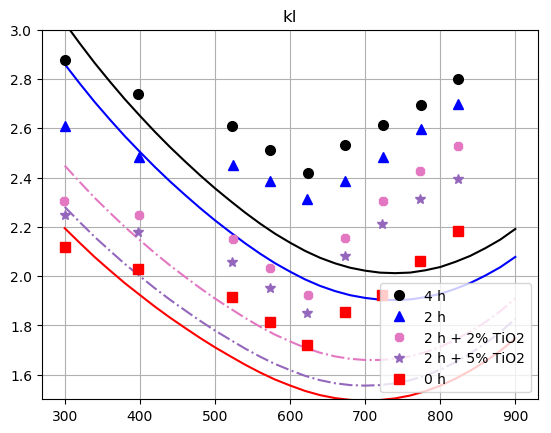

No handles with labels found to put in legend.


In [13]:
figure()
title("kl")
plot(Ts,36*klt_SA_A+kes[:,1,1]+0.6*kbis[:,1,1],Linestyle="-",color="k")
plot(Ts,34*klt_SA_A+kes[:,1,1]+0.567*kbis[:,1,1],Linestyle="-",color="b")
plot(Ts,28*klt_SA_A+1.48kes[:,1,1]+0.57*kbis[:,1,1],Linestyle="-",color="g")
plot(Ts,29*klt_SA_A+1.5kes[:,1,1]+0.53*kbis[:,1,1],Linestyle="-.",color="tab:pink")
plot(Ts,27*klt_SA_A+1.5kes[:,1,1]+0.53*kbis[:,1,1],Linestyle="-.",color="tab:purple")
plot(Ts,26*klt_SA_A+1.3kes[:,1,1]+0.52*kbis[:,1,1],Linestyle="-",color="r")
plot(MgSiSn4hKCT .+273,MgSiSn4hKCK,linestyle="None",marker="o",markersize=7,color="k")
plot(MgSiSn2hKCT .+273,MgSiSn2hKCK,linestyle="None",marker="^",markersize=7,color="b")
plot(MgSiSn05hKCT .+273,MgSiSn05hKCK,linestyle="None",marker="D",markersize=7,color="g")
plot(MgSiSn2h2TiO2KCT .+273,MgSiSn2h2TiO2KCK,linestyle="None",marker="8",markersize=7,color="tab:pink")
plot(MgSiSn2h5TiO2KCT .+273,MgSiSn2h5TiO2KCK,linestyle="None",marker="*",markersize=7,color="tab:purple")
plot(MgSiSn0hKCT .+273,MgSiSn0hKCK,linestyle="None",marker="s",markersize=7,color="r")
#plot(SiGe_SA_162_Bulk_KC_T,SiGe_SA_162_Bulk_KC_KL,linestyle="None",marker="o",markersize=7,color="b")
#plot(SiGe_SA_162_Bulk_KC_T2,SiGe_SA_162_Bulk_KC_K2,linestyle="None",marker="o",markersize=7,color="g")
legend(loc="upper left")
ylim(1.5,3.0)
grid()


figure()
title("kl")
plot(Ts,36 .*klt_SA_A .+kes[:,1,1]+0.6*kbis[:,1,1],Linestyle="-",color="k",label="")
plot(Ts,34 .*klt_SA_A .+kes[:,1,1]+0.567*kbis[:,1,1],Linestyle="-",color="b")
#plot(Ts,28*klt_SA_A+1.48kes[:,1,1]+0.57*kbis[:,1,1],Linestyle="-",color="g")
plot(Ts,29 .*klt_SA_A .+1.5kes[:,1,1]+0.53*kbis[:,1,1],Linestyle="-.",color="tab:pink")
plot(Ts,27 .*klt_SA_A .+1.5kes[:,1,1]+0.53*kbis[:,1,1],Linestyle="-.",color="tab:purple")
plot(Ts,26 .*klt_SA_A .+1.3kes[:,1,1]+0.52*kbis[:,1,1],Linestyle="-",color="r")
plot(MgSiSn4hKCT .+273,MgSiSn4hKCK,linestyle="None",marker="o",markersize=7,color="k",label="4 h")
plot(MgSiSn2hKCT .+273,MgSiSn2hKCK,linestyle="None",marker="^",markersize=7,color="b",label="2 h")
#plot(MgSiSn05hKCT+273,MgSiSn05hKCK,linestyle="None",marker="D",markersize=7,color="g")
plot(MgSiSn2h2TiO2KCT .+273,MgSiSn2h2TiO2KCK,linestyle="None",marker="8",markersize=7,color="tab:pink",label="2 h + 2% TiO2")
plot(MgSiSn2h5TiO2KCT .+273,MgSiSn2h5TiO2KCK,linestyle="None",marker="*",markersize=7,color="tab:purple",label="2 h + 5% TiO2")
plot(MgSiSn0hKCT .+273,MgSiSn0hKCK,linestyle="None",marker="s",markersize=7,color="r",label="0 h")
#plot(SiGe_SA_162_Bulk_KC_T,SiGe_SA_162_Bulk_KC_KL,linestyle="None",marker="o",markersize=7,color="b")
#plot(SiGe_SA_162_Bulk_KC_T2,SiGe_SA_162_Bulk_KC_K2,linestyle="None",marker="o",markersize=7,color="g")

ylim(1.5,3.0)
legend(loc="lower right")
grid()


In [14]:
MgSiSn4hECE=[10,12.4,20.5,35.8,43.2,69.6,82.8,100,110]
MgSiSn2hECE=[3,4.4,8.5,15.8,22.2,55.6,50.8,68,80]
MgSiSn1hECE=[2,4.2,3.7,11.8,22.2,25.6,30.8,48,64]
MgSiSn0hECE=[1.6,1.7,3.8,7.8,12.2,25.6,40.8,68,62]

9-element Array{Float64,1}:
  1.6
  1.7
  3.8
  7.8
 12.2
 25.6
 40.8
 68.0
 62.0

In [15]:

figure()
plot(Ts,sigmas[:,1,1]/100/6^(2/3),linestyle="-",color="b")
plot(Ts,sigmas[:,2,2]/100/6^(2/3),linestyle="-",color="r")
plot(Ts,sigmas[:,3,3]/100/6^(2/3),linestyle="-",color="k")
plot(Ts,sigmas[:,4,4]/100/6^(2/3),linestyle="-",color="g")
plot(MgSiSn4hKCT+273,MgSiSn4hECE,linestyle="None",marker=".",markersize=10,color="r")
plot(MgSiSn4hKCT+273,MgSiSn2hECE,linestyle="None",marker=".",markersize=10,color="k")
plot(MgSiSn4hKCT+273,MgSiSn1hECE,linestyle="None",marker=".",markersize=10,color="b")
plot(MgSiSn4hKCT+273,MgSiSn0hECE,linestyle="None",marker=".",markersize=10,color="g")
#plot(SiGe_Suin_EC_T,SiGe_Suin_Green_EC_E/100,linestyle="None",marker="x",markersize=2,color="g")
#plot(SiGe_Suin_EC_T,SiGe_Suin_Blue_EC_E/100,linestyle="None",marker="o",markersize=2,color="b")
#plot(SiGe_Suin_EC_T,SiGe_Suin_Pink_EC_E/100,linestyle="None",marker="o",markersize=2,color="r")
#plot(SiGe_Suin_EC_T,SiGe_Suin_Black_EC_E/100,linestyle="None",marker="o",markersize=2,color="k")
grid()

figure()
plot(Ts,-seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(Ts,-seebecks[:,2,2]*1e6,linestyle="-",color="r")
plot(Ts,-seebecks[:,3,3]*1e6,linestyle="-",color="k")
plot(Ts,-seebecks[:,4,4]*1e6,linestyle="-",color="g")
#plot(Ts,-seebecks[:,2,2]*1e6,linestyle="-",color="b")
#plot(SiGe_Vin_162_Bulk_SC_T,SiGe_Vin_162_Bulk_SC_S,linestyle="None",marker=".",markersize=10,color="r")
#plot(SiGe_Suin_EC_T,-SiGe_Suin_Green_SC_S,linestyle="None",marker="x",markersize=2,color="g")
#plot(SiGe_Suin_EC_T,-SiGe_Suin_Blue_SC_S,linestyle="None",marker="x",markersize=2,color="b")
#plot(SiGe_Suin_EC_T,-SiGe_Suin_Pink_SC_S,linestyle="None",marker="x",markersize=2,color="r")
#plot(SiGe_Suin_EC_T,-SiGe_Suin_Black_SC_S,linestyle="None",marker="x",markersize=2,color="k")
grid()

BoundsError: BoundsError: attempt to access 31×1×1 Array{Float64,3} at index [Base.Slice(Base.OneTo(31)), 2, 2]